- data exploration:
    - views by language
    - views by day of week
    - views by day of the year
    - total views per language overlaid with holidays
    - most viewed pages
    
- baseline models:
    - mean model
    - median model
    
- explorative arima:
    - best arima params
    - calculate smape for a few
    
- explorative prophet:
    - best prophet params: holidays, changepoints
    - look at components
    - plot forecasts
    - calculate smape for a few
    
- predictions:
    - find best model, calculate predictions
    - submit final to kaggle?

## Wikipedia Time Series Analysis
This project is a multiple time series project from Kaggle, with the goal being predicting Wikipedia web views for 145k different pages. Training data ranges from July 2015 to December 2016, and predictions range from January 2017 to March 2017. This notebook is 5 part:

1. Data exploration
2. Model tuning
3. Modeling evaluation and selection
4. Forecasting
5. Conclusion

### 1. Data exploration
This section explores patterns in the training data and implements some preprocessing for visualization:
1. Parse out language, article, and access type from the URL
2. Look at frequency across languages
3. Plot total views per language 
4. Plot sample of random web pages per language
5. Plot top 5 pages per language
6. Look at patterns by day of week, language 

In [1]:
#data manipulation and plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
import itertools

#time series modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.metrics import smape
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

#utilities
from tqdm import tqdm
import warnings
import os
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 
from datetime import date
import holidays

import logging
#logger = logging.getLogger('ftpuploader')
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
second_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_2.csv')

train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast='integer')

In [3]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [4]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis=1)

display(newtrain.head(2))
#newtrain['Total'] = newtrain.sum(axis=1)
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

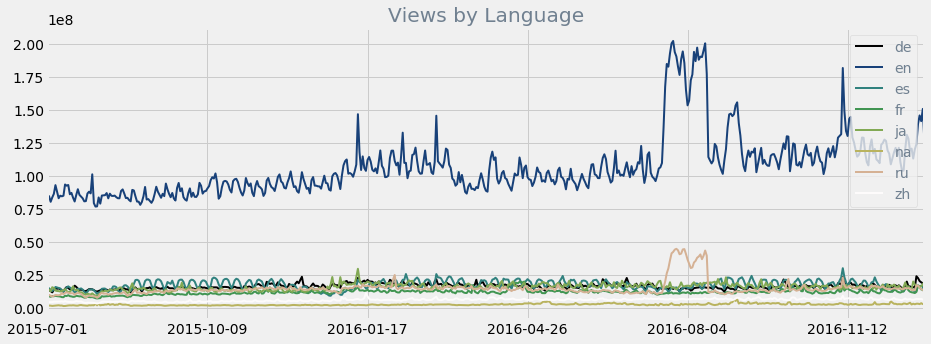

In [5]:
#plot the total views per language
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns=transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index=True, colormap="gist_earth", lw=2)
    title=plt.title('Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain.iloc[:,:-1], 'Language')

In [6]:
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[655 201 578]


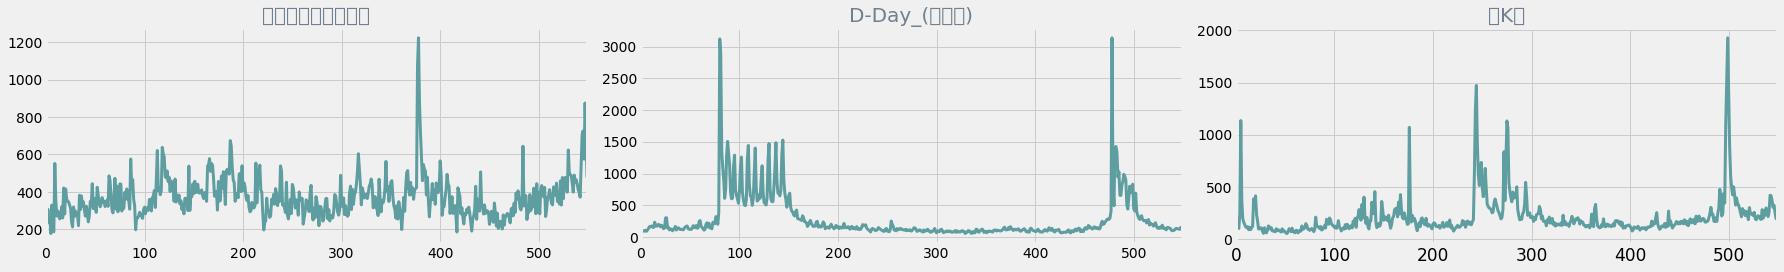

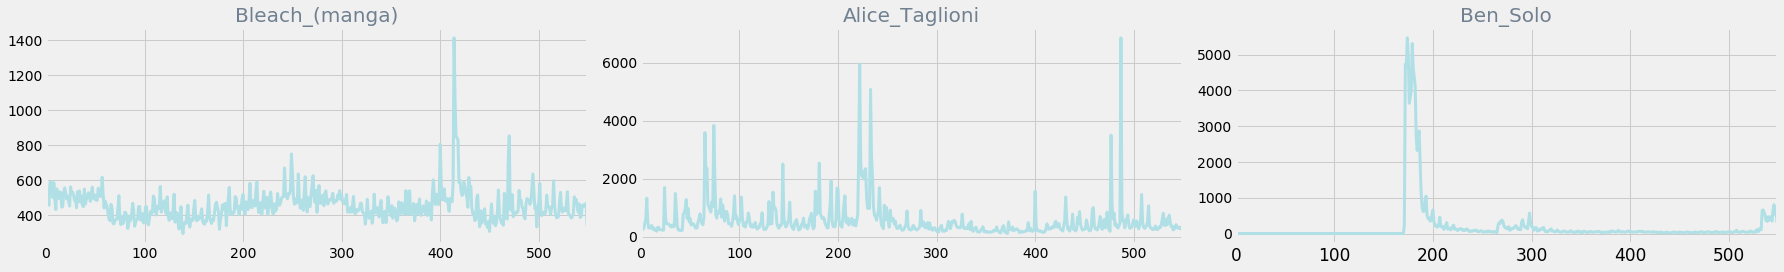

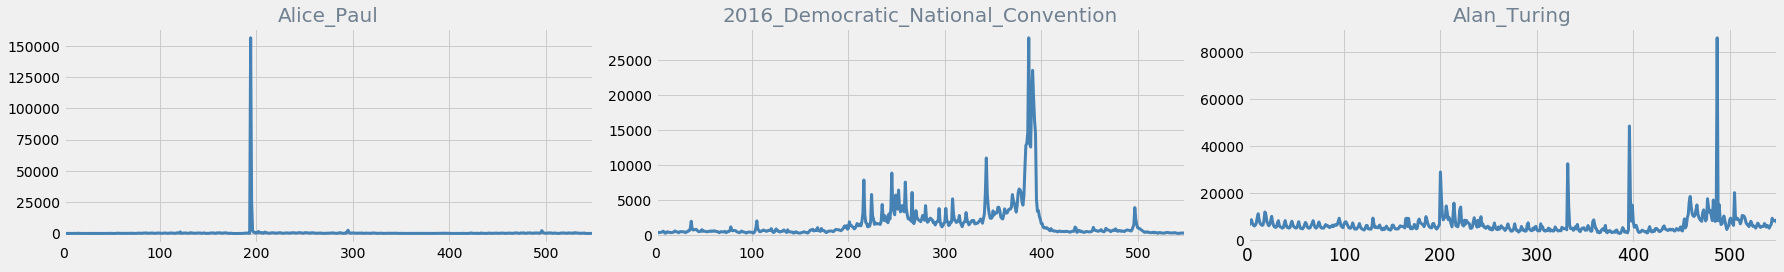

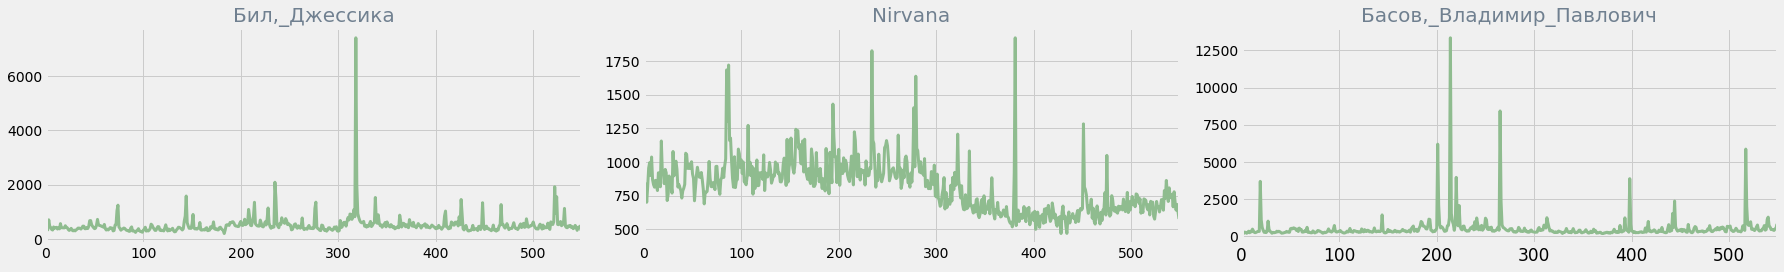

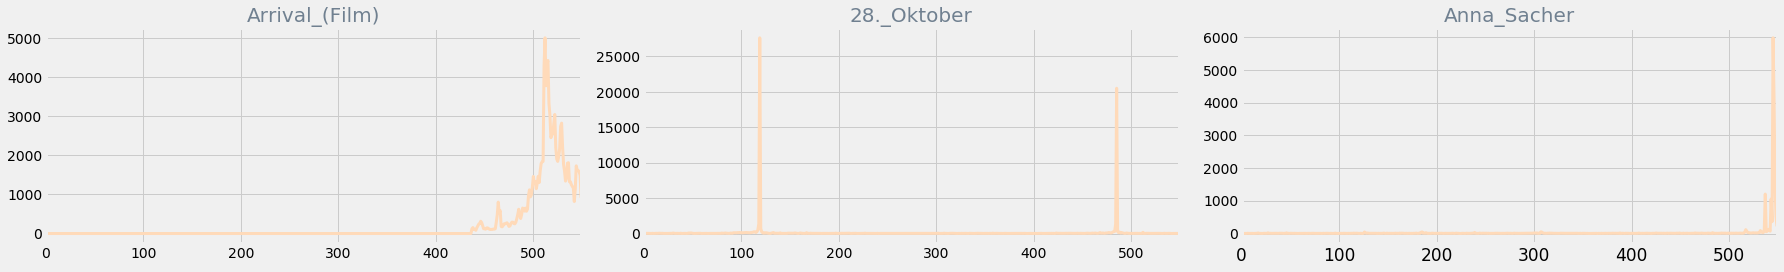

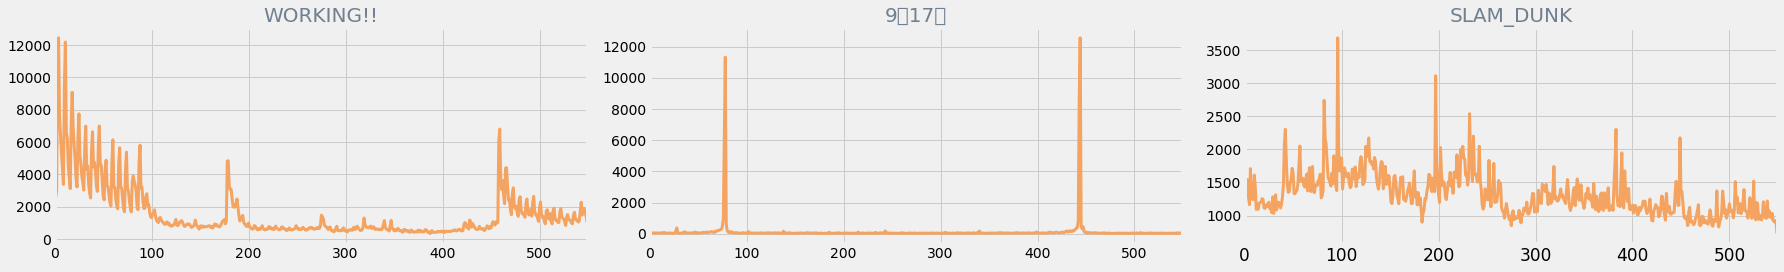

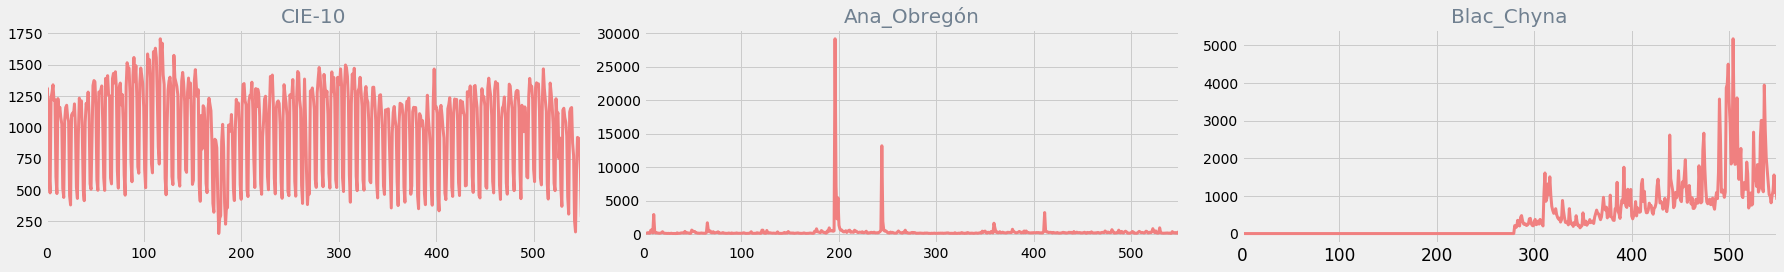

In [7]:
#plot a sample of pages for each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


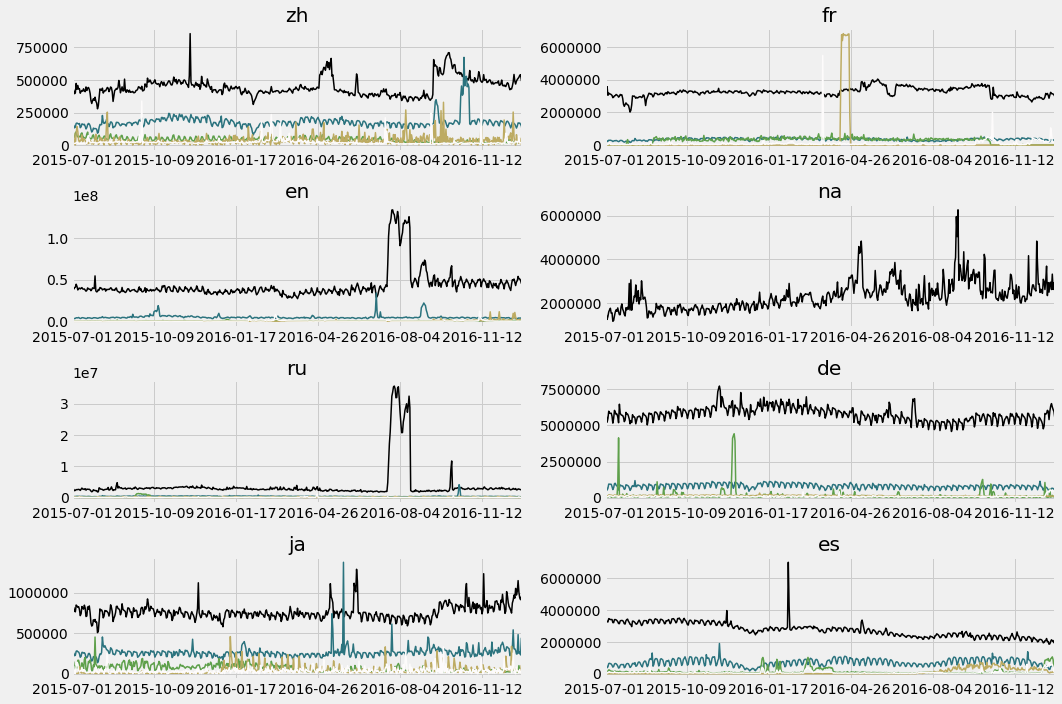

In [8]:
#plot top 5 pages for every language
fig, subaxes = plt.subplots(4,2,figsize=(15,10))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

In [9]:
#plot patterns across days of week, access type
transposed = train.iloc[:,1:-3].T
transposed.columns = train['Page']
transposed.index = pd.DatetimeIndex(transposed.index)

In [10]:
transposed.head()
transposed['DayName'] = transposed.index.day_name()

In [11]:
groupby_days = transposed.groupby('DayName').sum()

### Exploratory Modeling - ARIMA

In [47]:
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        
    def stationarity_check(self):
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
            
    def plot_diffs(self):
        plt.style.use('fivethirtyeight')
        ts = self.ts
        fig, axes = plt.subplots(3,3,figsize=(18,10))
        axes = axes.reshape(9,)
        for i in range(0,3):
            if i == 0:
                ts.plot(ax=axes[0], lw=2)
                plot_acf(ts, ax=axes[1])
                plot_pacf(ts, ax=axes[2])
                axes[0].set_title('Original Series')
            if i > 0:
                lag = ts.diff(i)
                axis_start = i**2+2
                lag.plot(ax=axes[axis_start], lw=2)
                plot_acf(lag[i:], ax=axes[axis_start+1])
                plot_pacf(lag[i:], ax=axes[axis_start+2])
                axes[axis_start].set_title('Lag of '+str(i))
            plt.tight_layout()
            
    def plot_rolling(self, n=12):
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def decompose(self, zoom=True):
        ts = self.ts
        #plt.style.use('seaborn')
        mul_result = seasonal_decompose(ts, model = 'multiplicative', period=7)
        plt.rcParams['figure.figsize'] = (10,4)
        fig = mul_result.plot().suptitle('Multiplicative')
        add_result = seasonal_decompose(ts, model = 'additive', period=7)
        #fig2 = add_result.plot().suptitle('Additive')
        if zoom:
            df = mul_result.seasonal.to_frame()
            df['day'] = df.index.day_name()
            df.index = df['day']
            df.drop('day',axis=1,inplace=True)
            fig = df[0:15].plot(kind='bar', figsize=(11,3), color='darkseagreen') 
            plt.title('Seasonal Trend')
            fig.get_legend().remove()
        return mul_result, add_result
            
    def auto_arima(self):
        ts = self.ts
        train, test = train_test_split(ts, test_size = 0.25)

        autoarima = pm.auto_arima(train, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise=True)

        train.plot(lw=3, label='actual train')
        test.plot(lw=3, label= 'actual test', color='yellowgreen')
        predictions, confint = autoarima.predict(test.shape[0], return_conf_int=True)

        predictions_series = pd.Series(predictions, index = test.index)
        predictions_series.plot(lw=3, color='orangered', label='predictions')
        fitted_series = pd.Series(autoarima.predict_in_sample(start=0, end=train.shape[0]-1), index = train.index)
        fitted_series.plot(lw=3, color='orangered', label='fitted')
        lower_series = pd.Series(confint[:, 0], index=test.index)
        upper_series = pd.Series(confint[:, 1], index=test.index)
        plt.fill_between(lower_series.index, lower_series, upper_series, color='gray',alpha=0.25)
        plt.legend(loc='upper left')
        
        display(autoarima.summary())
        fig = autoarima.plot_diagnostics(figsize=(10,6))
        plt.tight_layout()
    
        squared_error = mean_squared_error(test, predictions_series)
        mean_error = np.sqrt(squared_error)
        percent_error = mean_error/ts.mean()
        smape_value = smape(test, predictions_series)
        print(f'''
        mean error: {mean_error}
        percent_error: {percent_error}
        smape: {smape_value}''')
        return mean_error, percent_error, smape_value

In [48]:
#function to make a dataframe for any article
def make_df_article(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

def make_df_page(page):
    totals = newtrain[newtrain['Page']==page].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

#create timeseries object
myseries = make_df_article('Bill_Nye')
timeseries = TimeSeries(myseries)

adf: -9.638212792381553, 
p-value: 1.5459408542225872e-16,
stationary: True


TypeError: float() argument must be a string or a number, not 'Period'

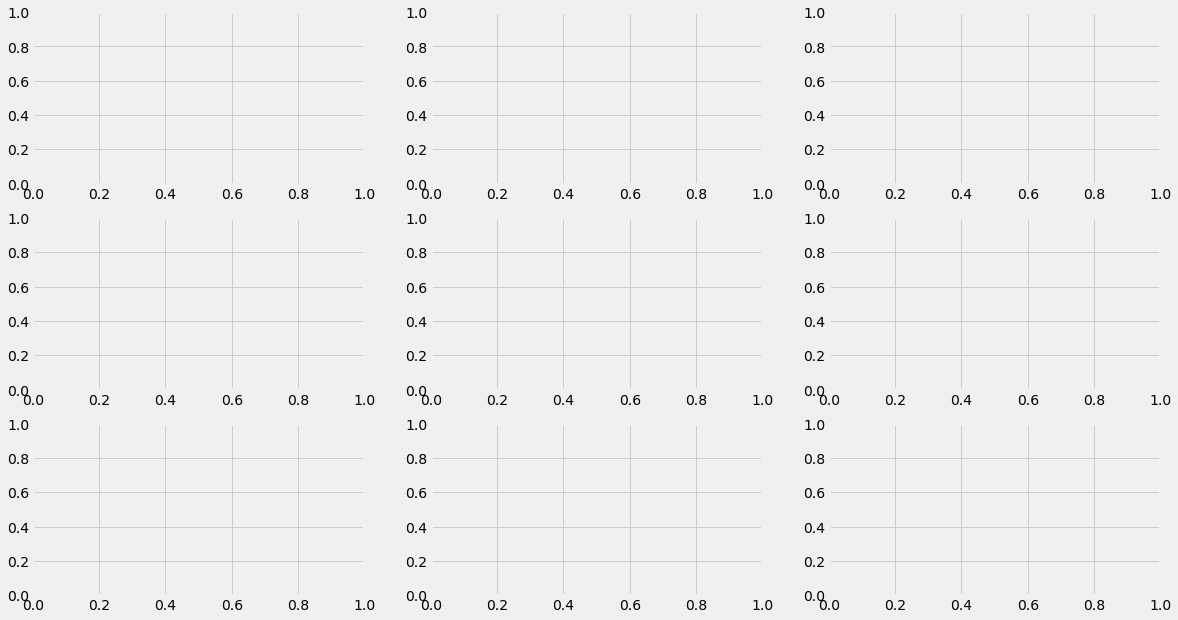

In [14]:
#call each method on the object
adf_statistic, pvalue, stationary = timeseries.stationarity_check()
print(f'''adf: {adf_statistic:}, 
p-value: {pvalue},
stationary: {stationary}''')

timeseries.plot_diffs()
timeseries.plot_rolling()
mul, add = timeseries.decompose()

TypeError: float() argument must be a string or a number, not 'Period'

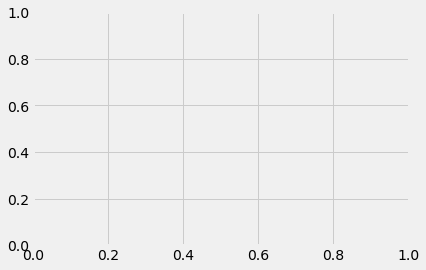

In [15]:
timeseries.auto_arima()

In [ ]:
#things to understand:
#aic
#smape
#ar vs ma process
#svg did not converge
#seasonal?

In [17]:
submission_key = pd.merge(submission, key)
datelist = pd.date_range('2017-01-01', periods=60).date.tolist()

class TSPrediction:
    def __init__(self, page):
        self.page = page
        self.ts = self.transform()
        self.test = self.make_predictions()[0]
        self.train = self.make_predictions()[1]
        self.autoarima = self.make_predictions()[2]
        self.predictions = self.make_predictions()[3]
        
    def transform(self):
        page = self.page
        ts = newtrain[newtrain['Page']==page]
        transposed = ts.T.iloc[4:]
        transposed.columns = ['Hits']
        return transposed
        
    def make_predictions(self):
        ts = self.ts
        page = self.page
        test, train = train_test_split(ts, test_size = 0.25)
        autoarima = pm.auto_arima(ts, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise = True)
        predictions = autoarima.predict(60)
        predictions = pd.DataFrame(predictions, index = datelist).rename(columns={0:'Predicted'})
        predictions['Page'] = [page + '_' + str(x) for x in predictions.index]
        return train, test, autoarima, predictions[['Page','Predicted']]

In [18]:
submission_key.head()

,Id,Visits,Page
0,bf4edcf969af,0,!vote_en.wikipedia.org_all-access_all-agents_2...
1,929ed2bf52b9,0,!vote_en.wikipedia.org_all-access_all-agents_2...
2,ff29d0f51d5c,0,!vote_en.wikipedia.org_all-access_all-agents_2...
3,e98873359be6,0,!vote_en.wikipedia.org_all-access_all-agents_2...
4,fa012434263a,0,!vote_en.wikipedia.org_all-access_all-agents_2...


In [19]:
pages = newtrain['Page']
submission_data = pd.DataFrame()

for i,page in (enumerate(pages)):
    if i<2:
        timeseries = TSPrediction(page)
        predicted_values = timeseries.predictions
        second_train_page = second_train[second_train['Page']==page].iloc[:,1:].T
        second_train_page.index = pd.DatetimeIndex(second_train_page.index)
        second_train_dates = second_train_page.loc['2017-01-01':'2017-03-01']
        second_train_dates.columns = ['Actual']
        predicted_df = pd.concat([predicted_values, second_train_dates],axis=1)
        submission_data = submission_data.append(predicted_df[['Page','Predicted','Actual']])
        
submission_data['Article'] = [x[0:len(x)-11] for x in submission_data['Page']]

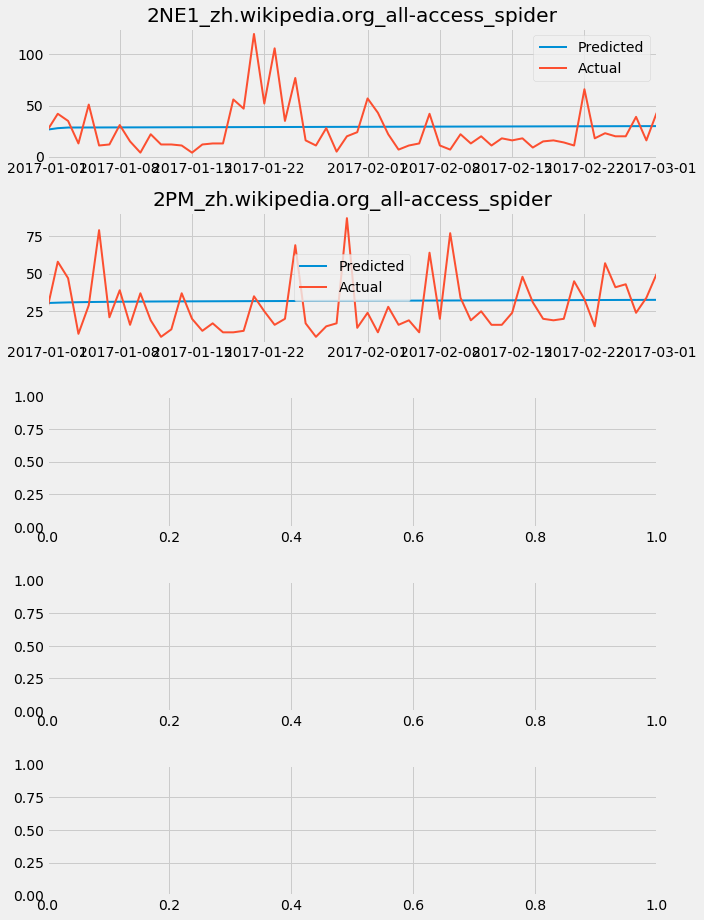

In [20]:
fig, axes = plt.subplots(5,1,figsize=(10,13))

for i,article in enumerate(submission_data['Article'].unique()):
    plotting = submission_data[submission_data['Article']==article]
    plotting[['Predicted','Actual']].plot(ax=axes[i],lw=2)
    axes[i].set_title(article)
plt.tight_layout()

In [21]:
smape(submission_data['Actual'],submission_data['Predicted'])

59.291750417620825

In [22]:

submission_data.head()
final_submission = pd.merge(submission_key, submission_data, how='inner',on='Page')
final_submission = final_submission[['Id','Predicted','Actual']]
final_submission.head()

,Id,Predicted,Actual
0,ff8c1aade3de,26.517722,26.0
1,6a4de5b43179,27.934241,42.0
2,559a1ab24535,28.565121,35.0
3,8bd4a4dea5a3,28.589668,13.0
4,fb31ab105824,28.614215,51.0


### Exploratory Modeling - Prophet


In [35]:
train[train['Page'].str.contains('CIE-10')==True]



,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,Article,Access
69689,CIE-10_es.wikipedia.org_desktop_all-agents,1270,1314,1202,631,477,1234,1281,1339,1214,...,166,656,920,913,909,657,284,es,CIE-10,desktop_all-agents
72293,"Anexo:CIE-10_Capítulo_XIX:_Traumatismos,_enven...",811,762,768,389,372,807,803,785,761,...,317,737,924,806,806,733,417,es,"Anexo:CIE-10_Capítulo_XIX:_Traumatismos,_enven...",desktop_all-agents


In [359]:
language_countries = {'fr':[holidays.France(years=[2015,2016]), holidays.Belgium(years=[2015,2016])],
                     'en':[holidays.UnitedStates(years=[2015,2016])],
                     'ru':[holidays.Russia(years=[2015,2016])],
                     'ja':[holidays.Japan(years=[2015,2016])],
                     'es':[holidays.Spain(years=[2015,2016])]}

def make_prophet_df(page):
    """
    Creates a dataframe with 'ds' and 'y' columns, as required for the Prophet model.
    Input is the full title of the wikipedia page, including article name, language, and access.
    """
    df = orig_train[orig_train['Page']==page].iloc[:,1:].T
    df = df.reset_index()
    df.columns = ['ds','y']
    return df


def remove_outliers(prophet_df):
    """
    Removes outliers from by deleting any records with a value below Q1-1.5(IQR) or above Q3+1.5(IQR). 
    Input is a dataframe with 'ds' and 'y' columns.
    """
    Q3 = prophet_df['y'].quantile(0.75)
    Q1 = prophet_df['y'].quantile(0.25)
    IQR = Q3-Q1
    df_no_outliers = prophet_df.loc[prophet_df['y'].between(Q1-1.5*IQR, Q3+1.5*IQR)]
    num_outliers = sum(prophet_df['y'].between(Q1-1.5*IQR, Q3+1.5*IQR)==False)
    print (f'{num_outliers} outliers removed')
    return df_no_outliers


def holiday_df(language):
    """
    Creates a dataframe of holidays for countries speaking the given language.
    """
    all_holidays = pd.DataFrame()
    holiday_items = language_countries[language]
    for i,item in enumerate(holiday_items):
        holiday_df = pd.DataFrame(sorted(holiday_items[i].items()))
        all_holidays = all_holidays.append(holiday_df)
    all_holidays.rename(columns={0:'ds',1:'holiday'},inplace=True)
    all_holidays.reset_index(inplace=True,drop=True)
    return all_holidays


def plot_holidays(holidays_df, original, **kwargs):
    """
    Plots original time series and time series with no outliers against holidays
    """
    pd.plotting.register_matplotlib_converters()
    fig, axes = plt.subplots(1,2,figsize=(12,4), sharex=True)
    #convert index to dates, plot
    original.index = pd.to_datetime(original['ds'])
    orig = original['y'].plot(ax=axes[0])
    for date in holidays_df['ds']:
        orig.axvline(x=date, color='green', alpha = 0.3, ls='--')
    orig.set_title('Original')
    
    if kwargs:
        no_outliers.index = pd.to_datetime(no_outliers['ds'])
        cleaned = no_outliers['y'].plot(ax=axes[1])
        for date in holidays_df['ds']:
            cleaned.axvline(x=date, color='green', alpha = 0.3, ls='--')
        cleaned.set_title('No Outliers')

        
def fit_prophet(df, holiday_df, plot_components=False, plot_forecast=False, metrics=False):
    """
    Fits prophet model on a dataframe with 'ds' and 'y' columns for a range of changepoint prior scales.
    Plots fitted values and forecasts for each changepoint prior scale. 
    Returns table of forecasts.
    """
    marker = int(df.shape[0]*0.75)
    train = df[0:marker]
    test = df[marker:]
    
    if plot_forecast:
        fig, axes_forecast = plt.subplots(2,2,figsize=(13,6))
        axes_forecast=axes_forecast.reshape(-1)
    if metrics:
        fig, axes_metrics = plt.subplots(2,2,figsize=(13,6))
        axes_metrics=axes_metrics.reshape(-1)
    
    all_forecasts=pd.DataFrame()
    for i, changepoint in enumerate([0.01, 0.5, 10, 30]):
        prophet = Prophet(changepoint_prior_scale=changepoint).fit(train)
        future = prophet.make_future_dataframe(periods=len(test)+60)
        forecast = prophet.predict(future)
        forecast['changepoint'] = changepoint
        all_forecasts = all_forecasts.append(forecast)
        if plot_forecast:
            fig1 = prophet.plot(forecast,ax=axes_forecast[i])
            axes_forecast[i].set_title(changepoint)
            a = add_changepoints_to_plot(axes_forecast[i], prophet, forecast)
        if plot_components:
            fig = prophet.plot_components(forecast, figsize=(7,5))
            plt.tight_layout()
        if metrics:    
            total_metrics = pd.DataFrame()
            prophet_cv = cross_validation(prophet, initial='31 days', horizon='30 days')
            metrics = performance_metrics(prophet_cv)
            metrics['changepoint'] = changepoint
            fig=plot_cross_validation_metric(prophet_cv, metric='mape', figsize=(7,3), ax=axes_metrics[i])
            plt.title(changepoint)
            total_metrics = total_metrics.append(metrics)
            total_metrics['days'] = [int(str(x)[0:(len(str(x)))-14]) for x in total_metrics['horizon']]
            return forecast, total_metrics
    return all_forecasts

    
def compare_actuals(forecast, page):
    """
    Create dataframe of actuals vs. predicted for 7/1/2015 to 3/1/2016.
    """
    pd.plotting.register_matplotlib_converters()
    actual = second_train[second_train['Page']==page].T[1:]
    actual.index = pd.to_datetime(actual.index)
    forecast = forecast[['ds','yhat','changepoint']]
    actual_predicted = pd.merge(actual, forecast, how='outer', left_index=True, right_on='ds')
    actual_predicted.index=actual_predicted['ds']
    actual_predicted.drop('ds',axis=1,inplace=True)
    actual_predicted[10091] = actual_predicted[10091].astype(float)
    actual_predicted.plot()
    return actual_predicted

57 outliers removed


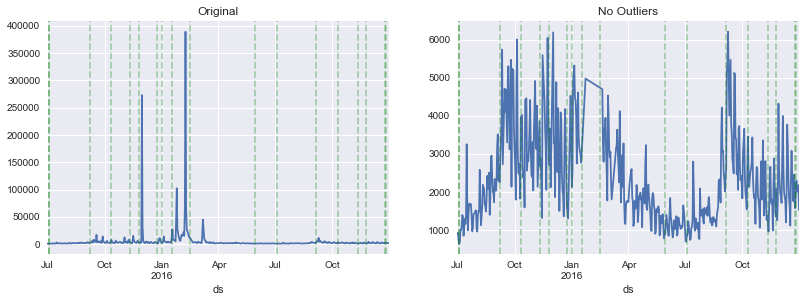

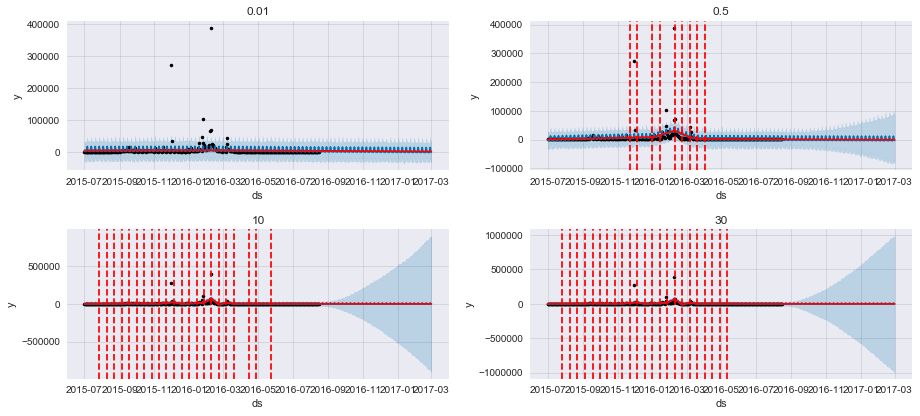

In [360]:
#call each of the prophet functions on a sample page
#make the prophet dataframe
page = 'Peyton_Manning_en.wikipedia.org_desktop_all-agents'
prophet_df = make_prophet_df(page)

cleaned_df = remove_outliers(prophet_df)

plot_holidays(holidays_en, prophet_df, no_outliers=cleaned_df)

forecast = fit_prophet(prophet_df, holiday_df, plot_forecast=True)

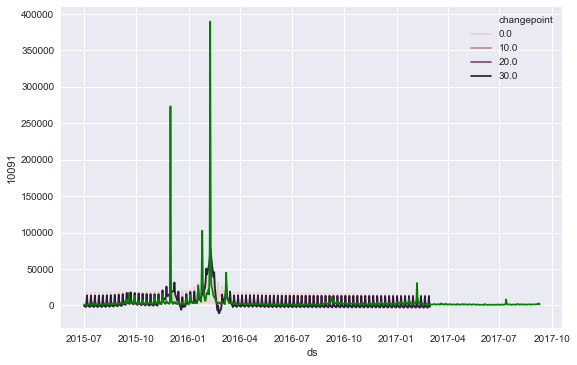

In [364]:
pd.plotting.register_matplotlib_converters()
actual = second_train[second_train['Page']==page].T[1:]
actual.index = pd.to_datetime(actual.index)
forecast = forecast[['ds','yhat','changepoint']]
actual_predicted = pd.merge(actual, forecast, how='outer', left_index=True, right_on='ds')
actual_predicted.index=actual_predicted['ds']
actual_predicted.drop('ds',axis=1,inplace=True)
actual_predicted[10091] = actual_predicted[10091].astype(float)
sns.lineplot(actual_predicted.index, actual_predicted['yhat'], hue=actual_predicted['changepoint'])
sns.lineplot(actual_predicted.index, actual_predicted[10091], color='g')